## Group Project: Financial Security Analysis and Portfolio Mgmt.
**By: Ashish Mathew, Bowen Gu**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy import stats
from scipy.optimize import minimize
import warnings
from datetime import datetime, timedelta

warnings.filterwarnings('ignore')
%matplotlib inline

### Part I: Portfolio Optimization

In [126]:
def pullPriceData(tickers,start_date,end_date,verbose=True):
    df = yf.download(tickers,start_date,end_date)
    df = df['Close']
    daily_return = df.pct_change().dropna()

    tbill_data = pd.read_csv('./data/TB3MS.csv')
    tbill_data['observation_date'] = pd.to_datetime(tbill_data['observation_date']).dt.date
    
    filter_condition = (tbill_data['observation_date'] >= start_date) & \
        (tbill_data['observation_date'] <= end_date)
    
    tbill_data = tbill_data.loc[filter_condition]
    tbill_data['daily_rfr'] = (1 + tbill_data['TB3MS']/100) ** (1/360) -1

    if verbose:
        for ticker in tickers:
            print(f"---Daily Return Characteristics of {ticker}---")
            print(f"Average: {100*np.mean(daily_return[ticker]):.2f}%")
            print(f"Variance: {1e4*np.var(daily_return[ticker]):.4f}")
            print(f"Standard Deviation: {100*np.std(daily_return[ticker]):.2f}%")
            print(f"Skewness: {stats.skew(daily_return[ticker])}")
            print(f"Kurtosis: {stats.kurtosis(daily_return[ticker])}")
            print("\n")

        print("---Covariance of Daily Return---")
        print(daily_return.cov())
        print("\n")
        print("---Correlation of Daily Returns---")
        print(daily_return.corr())
        print("\n")
        print("---Treasury Bill Data---")
        print(f"Average Annualized Risk-Free Rate: {np.mean(tbill_data['TB3MS']):.2f}%")
        print(f"Average Daily Risk-Free Rate: {np.mean(tbill_data['daily_rfr']*100):.4f}%")

    return daily_return, tbill_data['daily_rfr']

def portfolioCharacteristics(returns,weights,verbose=True):
    portfolio_returns = np.dot(weights,returns.T)
    mean_return = np.mean(portfolio_returns)
    mean_return = ((1 + mean_return) ** 252) - 1
    std_return = np.std(portfolio_returns) * np.sqrt(252)
    

    if verbose:
        print("---Portfolio Characteristics---")
        print(f"Average Return: {100 * mean_return:.2f}%")
        print(f"Average Standard Deviation: {100*std_return:.2f}%")
    
    return portfolio_returns, mean_return, std_return

def plotEfficientFrontier(returns,rfr):
    weights = []
    portfolio_returns = []
    portfolio_risk = []
    num_assets = returns.shape[1]
    
    for _ in range(3_000):
        w = np.random.rand(num_assets)
        w = w / w.sum()
        _, ret, vol = portfolioCharacteristics(returns,w,verbose=False)
        weights.append(w)
        portfolio_returns.append(ret)
        portfolio_risk.append(vol)

    
    portfolio_sharpe = [(ret - rfr)/vol for ret, vol in zip(portfolio_returns,portfolio_risk)]
    
    max_sharpe = np.argmax(portfolio_sharpe)
    min_var = np.argmin(portfolio_risk)

    cal_slope = portfolio_sharpe[max_sharpe]
    x_vals = np.linspace(np.min(portfolio_risk),np.max(portfolio_risk),100)
    y_vals = rfr + cal_slope * x_vals
    

    plt.figure(figsize=(6,6))
    plt.title("Efficient Frontier")
    sns.scatterplot(x=portfolio_risk,y=portfolio_returns)
    plt.scatter(x=portfolio_risk[max_sharpe],y=portfolio_returns[max_sharpe],label='Max. Sharpe',color='red')
    plt.scatter(x=portfolio_risk[min_var],y=portfolio_returns[min_var],label='Min. Variance',color='green')
    #plt.plot([0, portfolio_risk[max_sharpe]], [rfr, portfolio_returns[max_sharpe]], color='black', linestyle='--', linewidth=2)
    plt.xlim(0,1)
    plt.xlabel('Portfolio Risk')
    plt.ylabel('Portfolio Returns')
    plt.legend()
    plt.show()

In [129]:
tickers = ['AXP','WMT','NRG','AAPL','TSLA']
start_date = datetime(2024,1,1).date()
end_date = datetime(2024,12,31).date()

daily_return, tbill_data = pullPriceData(tickers,start_date,end_date)

[*********************100%***********************]  5 of 5 completed

---Daily Return Characteristics of AXP---
Average: 0.20%
Variance: 2.3148
Standard Deviation: 1.52%
Skewness: 0.34603492621555654
Kurtosis: 4.606994591269732


---Daily Return Characteristics of WMT---
Average: 0.22%
Variance: 1.2428
Standard Deviation: 1.11%
Skewness: 1.517187085040419
Kurtosis: 8.459611597731183


---Daily Return Characteristics of NRG---
Average: 0.27%
Variance: 5.0492
Standard Deviation: 2.25%
Skewness: 0.2640557674739151
Kurtosis: 2.3431393979809076


---Daily Return Characteristics of AAPL---
Average: 0.13%
Variance: 1.9918
Standard Deviation: 1.41%
Skewness: 0.4951730440275659
Kurtosis: 3.6337875125750587


---Daily Return Characteristics of TSLA---
Average: 0.29%
Variance: 16.0126
Standard Deviation: 4.00%
Skewness: 0.8800406299586017
Kurtosis: 4.380142553140811


---Covariance of Daily Return---
Ticker      AAPL       AXP       NRG      TSLA       WMT
Ticker                                                  
AAPL    0.000200  0.000017  0.000040  0.000186  0.000

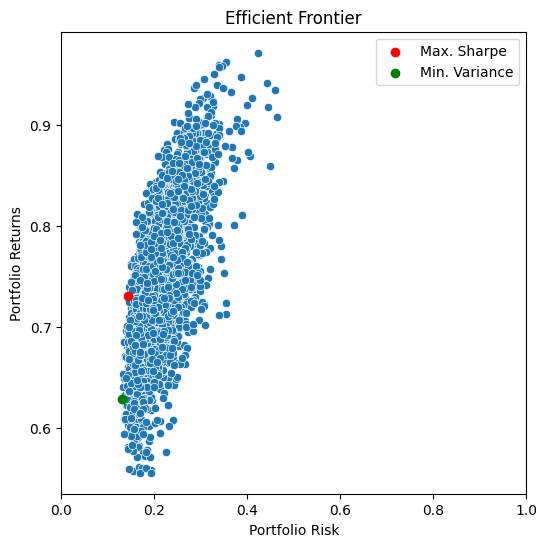

In [130]:
plotEfficientFrontier(daily_return,0.0479)

In [79]:
def return_characteristics(tickers,end_date,start_date,verbose=True):
    """
    Calculate descriptive statistics and covariance structure for stock returns 
    over a given lookback period, along with the average daily risk-free rate.

    Parameters
    ----------
    tickers : list of str
        A list of stock ticker symbols to analyze.
    end_date : datetime.date or datetime.datetime
        The end date for the analysis period.
    lookback : int
        Number of years to look back from the `end_date` for historical data.
    verbose : bool, optional (default=True)
        If True, prints detailed return statistics, covariance/correlation 
        matrices, and Treasury bill data to the console.

    Returns
    -------
    mean_returns : pandas.Series
        The average daily returns for each ticker over the lookback period.
    cov_matrix : pandas.DataFrame
        The covariance matrix of daily returns.
    avg_daily_rfr : float
        The average daily risk-free rate over the period, based on 3-month 
        Treasury bill rates.
    """
    
    data = yf.download(tickers=tickers,start=start_date,end=end_date)

    tbill_data = pd.read_csv('./data/TB3MS.csv')
    tbill_data['observation_date'] = pd.to_datetime(tbill_data['observation_date']).dt.date
    
    filter_condition = (tbill_data['observation_date'] >= start_date) & \
        (tbill_data['observation_date'] <= end_date)
    
    tbill_data = tbill_data.loc[filter_condition]
    tbill_data['daily_rfr'] = (1 + tbill_data['TB3MS']/100) ** (1/360) -1

    prices = data['Close']
    daily_return = prices.pct_change().dropna()
    if verbose:
        for ticker in tickers:
            print(f"---Daily Return Characteristics of {ticker}---")
            print(f"Average: {100*np.mean(daily_return[ticker]):.2f}%")
            print(f"Variance: {1e4*np.var(daily_return[ticker]):.4f}")
            print(f"Standard Deviation: {100*np.std(daily_return[ticker]):.2f}%")
            print(f"Skewness: {stats.skew(daily_return[ticker])}")
            print(f"Kurtosis: {stats.kurtosis(daily_return[ticker])}")
            print("\n")

        print("---Covariance of Daily Return---")
        print(daily_return.cov())
        print("\n")
        print("---Correlation of Daily Returns---")
        print(daily_return.corr())
        print("\n")
        print("---Treasury Bill Data---")
        print(f"Average Annualized Risk-Free Rate: {np.mean(tbill_data['TB3MS']):.2f}%")
        print(f"Average Daily Risk-Free Rate: {np.mean(tbill_data['daily_rfr']*100):.4f}%")
    
    return daily_return.mean(), daily_return.cov(), np.mean(tbill_data['daily_rfr'])

def portfolio_performance(weights,mean_returns,cov_matrix):
    """
    Calculate the expected daily return and volatility of a portfolio.

    Parameters
    ----------
    weights : array-like
        Portfolio weights for each asset. Must sum to 1.
    mean_returns : array-like or pandas.Series
        Daily mean returns for each asset.
    cov_matrix : array-like or pandas.DataFrame
        Annualized covariance matrix of asset returns.

    Returns
    -------
    ret : float
        Expected daily portfolio return.
    vol : float
        Expected daily portfolio volatility (standard deviation).
    """

    ret = np.dot(weights, mean_returns)
    vol = np.sqrt(np.dot(weights.T,np.dot(cov_matrix,weights)))
    return ret, vol

def portfolio_volatility(weights,mean_returns,cov_matrix,rfr):
    vol = np.sqrt(np.dot(weights.T,np.dot(cov_matrix,weights)))
    return vol

def negative_sharpe_ratio(weights,mean_returns,cov_matrix,rfr):
    """
    Calculate the negative Sharpe ratio of a portfolio.

    Parameters
    ----------
    weights : array-like
        Portfolio weights for each asset. Must sum to 1.
    mean_returns : array-like or pandas.Series
        Daily mean returns for each asset.
    cov_matrix : array-like or pandas.DataFrame
        Daily covariance matrix of asset returns.
    rfr : float
        Daily risk-free rate.

    Returns
    -------
    neg_sharpe : float
        Negative of the portfolio's Sharpe ratio.
    """
    ret, vol = portfolio_performance(weights,mean_returns,cov_matrix)
    return -(ret-rfr) / vol

def optimal_portfolio_weights(mean_returns,cov_matrix,rfr):
    """
    Determine the portfolio weights that maximize the Sharpe ratio.

    Parameters
    ----------
    mean_returns : array-like or pandas.Series
        Annualized mean returns for each asset.
    cov_matrix : array-like or pandas.DataFrame
        Annualized covariance matrix of asset returns.
    rfr : float
        Annualized risk-free rate.

    Returns
    -------
    optimal_weights : numpy.ndarray
        Array of optimal portfolio weights that maximize the Sharpe ratio. 
        Weights sum to 1.
    """
    num_assets = len(mean_returns)
    init_weights = num_assets * [1. / num_assets]
    constraint = {'type':'eq', 'fun': lambda x: np.sum(x)-1}

    result = minimize(
        negative_sharpe_ratio, 
        init_weights, 
        args=(mean_returns,cov_matrix,rfr),
        method='SLSQP',
        constraints=constraint
    )

    optimal_weights = result.x
    return optimal_weights

def plot_returns(tickers,end_date,start_date,weights):
    """
    Plots the cumulative returns of the S&P 500 (SPY), a maximum Sharpe ratio portfolio,
    and an equally weighted portfolio over a specified date range.

    This function:
      1. Downloads historical closing prices for the given asset tickers and the S&P 500 (SPY).
      2. Constructs two portfolios:
         - A portfolio using the provided weights for Max. Sharpe portfolio
         - An equally weighted portfolio of the given tickers.
      3. Normalizes returns to start at 100 for easy comparison.
      4. Plots all three return series on the same chart.

    Parameters
    ----------
    tickers : list of str
        List of asset ticker symbols to include in the portfolios.
    end_date : str
        End date for the historical data in 'YYYY-MM-DD' format.
    start_date : str
        Start date for the historical data in 'YYYY-MM-DD' format.
    weights : array-like
        Portfolio weights corresponding to `tickers` (should sum to 1).
    """

    data = yf.download(tickers=tickers,start=start_date,end=end_date)
    spy = yf.download(tickers='SPY',start=start_date,end=end_date)

    prices = data['Close']
    spy_prices = spy['Close']

    num_assets = len(tickers)
    eq_weights = np.array(num_assets * [1. / num_assets])

    max_sharpe = np.dot(weights,prices.T)
    eq_portfolio = np.dot(eq_weights,prices.T)

    prices['SPY'] = spy_prices
    prices['Max. Sharpe'] = max_sharpe
    prices['Equal Portfolio'] = eq_portfolio

    prices = 100 * prices / prices.iloc[0]

    plt.figure(figsize=(6,6))
    sns.lineplot(data=prices,x=prices.index,y='SPY',label='S&P500')
    sns.lineplot(data=prices,x=prices.index,y='Max. Sharpe',label='Max. Sharpe')
    sns.lineplot(data=prices,x=prices.index,y='Equal Portfolio',label='Equal Port.')
    plt.ylabel('Prices')
    plt.show()

def wrapper(tickers,end_date,start_date,verbose=True):
    """
    Compute and display the optimal portfolio weights for a given set of tickers.

    Parameters
    ----------
    tickers : list of str
        List of stock ticker symbols to analyze.
    end_date : datetime.date or datetime.datetime
        End date for the analysis period.
    lookback : int
        Number of years to look back from `end_date` for historical data.
    verbose : bool, optional (default=True)
        If True, prints detailed return characteristics and intermediate 
        statistics from `return_characteristics`.

    Returns
    -------
    None
        Prints the optimal portfolio weights to the console.
    """
    mean_returns, cov_matrix, rfr = return_characteristics(tickers,end_date,start_date,verbose)
    optimal_weights = optimal_portfolio_weights(mean_returns,cov_matrix,rfr)
    print("\n")
    print("Optimal Portfolio Weights")
    for ticker, weight in zip(tickers,optimal_weights):
        print(f"{ticker}:{weight:.2f}")
    
    
    plot_returns(tickers,end_date,start_date,optimal_weights)

    return optimal_weights

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed

---Daily Return Characteristics of AXP---
Average: 0.20%
Variance: 2.3148
Standard Deviation: 1.52%
Skewness: 0.3460382360503865
Kurtosis: 4.606993489136408


---Daily Return Characteristics of WMT---
Average: 0.22%
Variance: 1.2428
Standard Deviation: 1.11%
Skewness: 1.5171898027598942
Kurtosis: 8.459631726757483


---Daily Return Characteristics of TSLA---
Average: 0.29%
Variance: 16.0126
Standard Deviation: 4.00%
Skewness: 0.8800406299586017
Kurtosis: 4.380142553140811


---Covariance of Daily Return---
Ticker       AXP      TSLA       WMT
Ticker                              
AXP     0.000232  0.000176  0.000028
TSLA    0.000176  0.001608  0.000064
WMT     0.000028  0.000064  0.000125


---Correlation of Daily Returns---
Ticker       AXP      TSLA       WMT
Ticker                              
AXP     1.000000  0.287438  0.163139
TSLA    0.287438  1.000000  0.143024
WMT     0.163139  0.143024  1.000000


---Treasury Bill Data---
Average Annualized Risk-Free Rate: 4.97%
Average Daily

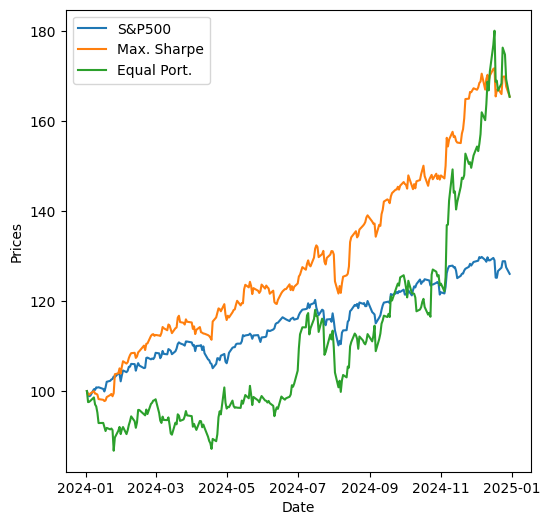

In [82]:
# Generate return characteristics of selected stockcs for the desired date range
# Calculate optimal portfolio weights for a Max Sharpe ratio
# Plot returns of the S&P500, Equal Weight portfolio and Max. Sharpe Portfolio

end_date = datetime(2024,12,31).date()
start_date = end_date - timedelta(days=365)
tickers = [
    'AXP',      # American Express
    'WMT',      # Walmart
    'TSLA',     # Tesla
    ]

optimal_weights = wrapper(tickers,end_date,start_date,verbose=True)

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed


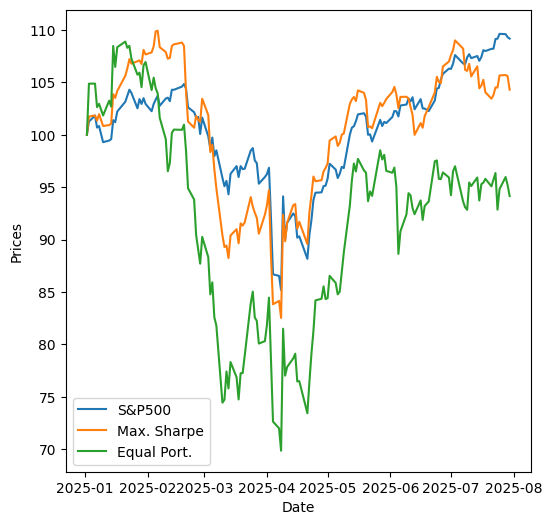

In [83]:
# Out of sample evaluation of portfolios
start_date = datetime(2025,1,1).date()
end_date = datetime(2025,7,31).date()
plot_returns(tickers,end_date,start_date,optimal_weights)

In [87]:
daily_return.head()

Ticker,AXP,TSLA,WMT,portfolio
Date,,,,
2024-01-03,-0.010568,-0.040134,0.000063,-0.010568
2024-01-04,0.007646,-0.002181,-0.009667,0.007646
2024-01-05,0.010260,-0.001849,-0.006656,0.010260
2024-01-08,0.000793,0.012464,0.009827,0.000793
2024-01-09,-0.012896,-0.022832,0.006698,-0.012896


In [94]:
weights = []
portfolio_returns = []
portfolio_risk = []
num_assets = daily_return.shape[1]

for _ in range(500):
    w = np.random.rand(num_assets)
    w = w / w.sum()
    _, ret, vol = portfolioCharacteristics(daily_return,w,verbose=False)
    weights.append(w)
    portfolio_returns.append(ret)
    portfolio_risk.append(vol)

rfr = 0.04
[(ret - rfr)/vol for ret, vol in zip(portfolio_returns,portfolio_risk)]

[np.float64(2.8671062429738994),
 np.float64(2.414862990033236),
 np.float64(3.036115129657244),
 np.float64(2.0325500988941503),
 np.float64(2.703650315371076),
 np.float64(2.5695924574841924),
 np.float64(2.8761757351498076),
 np.float64(3.0911322783920925),
 np.float64(3.5331010624071832),
 np.float64(3.1822991142177095),
 np.float64(2.410863653464064),
 np.float64(2.8578450119334855),
 np.float64(2.917259400903551),
 np.float64(3.0191526410753933),
 np.float64(2.6521010398194176),
 np.float64(3.6926877426425477),
 np.float64(2.3105872842447366),
 np.float64(2.8140108185597916),
 np.float64(3.0852375884943504),
 np.float64(3.0185883884041442),
 np.float64(2.881213826887358),
 np.float64(2.7085440174599884),
 np.float64(2.9239152188278967),
 np.float64(2.4812115039117604),
 np.float64(3.1699800990972538),
 np.float64(2.88408891057193),
 np.float64(2.67017237124993),
 np.float64(3.4776144243957288),
 np.float64(3.0952584114440453),
 np.float64(2.8539179469982923),
 np.float64(3.402412